<a href="https://colab.research.google.com/github/Vasanta2002/sprint_6/blob/main/JDS_SHR_222_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BloomTech Data Science

---

# Random Forests

- use scikit-learn for **random forests**
- do **ordinal encoding** with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

In [1]:
%%capture

!pip install category_encoders==2.*

In [2]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API. 

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [3]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contians the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so. 
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge 

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [5]:
# List all files in your Kaggle folder on your google drive.
!ls

bloomtech-water-pump-challenge.zip  sample_submission.csv  train_labels.csv
kaggle.json			    test_features.csv
new_submission.csv		    train_features.csv


# I. Wrangle Data

In [6]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, 
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns
  dupe_cols = [col for col in df.head(100).T.duplicated().index # change 15 to 100!!!!
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)             

  return df

# add the datapath if needed
df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv') 

In [7]:
df.shape, X_test.shape

((47519, 31), (11880, 30))

# II. Split Data

## Split TV from FM

In [8]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

# Training-Validation Split

- Randomized split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

In [10]:
print('baseline accuracy:', y_train.value_counts(normalize=True).max())

baseline accuracy: 0.5425489938182296


# IV. Build Model(s)

- Missing values
- Categorical values

**First Model:** Decision Trees

In [11]:
# Decision Tree
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
)

model_dt.fit(X_train, y_train);

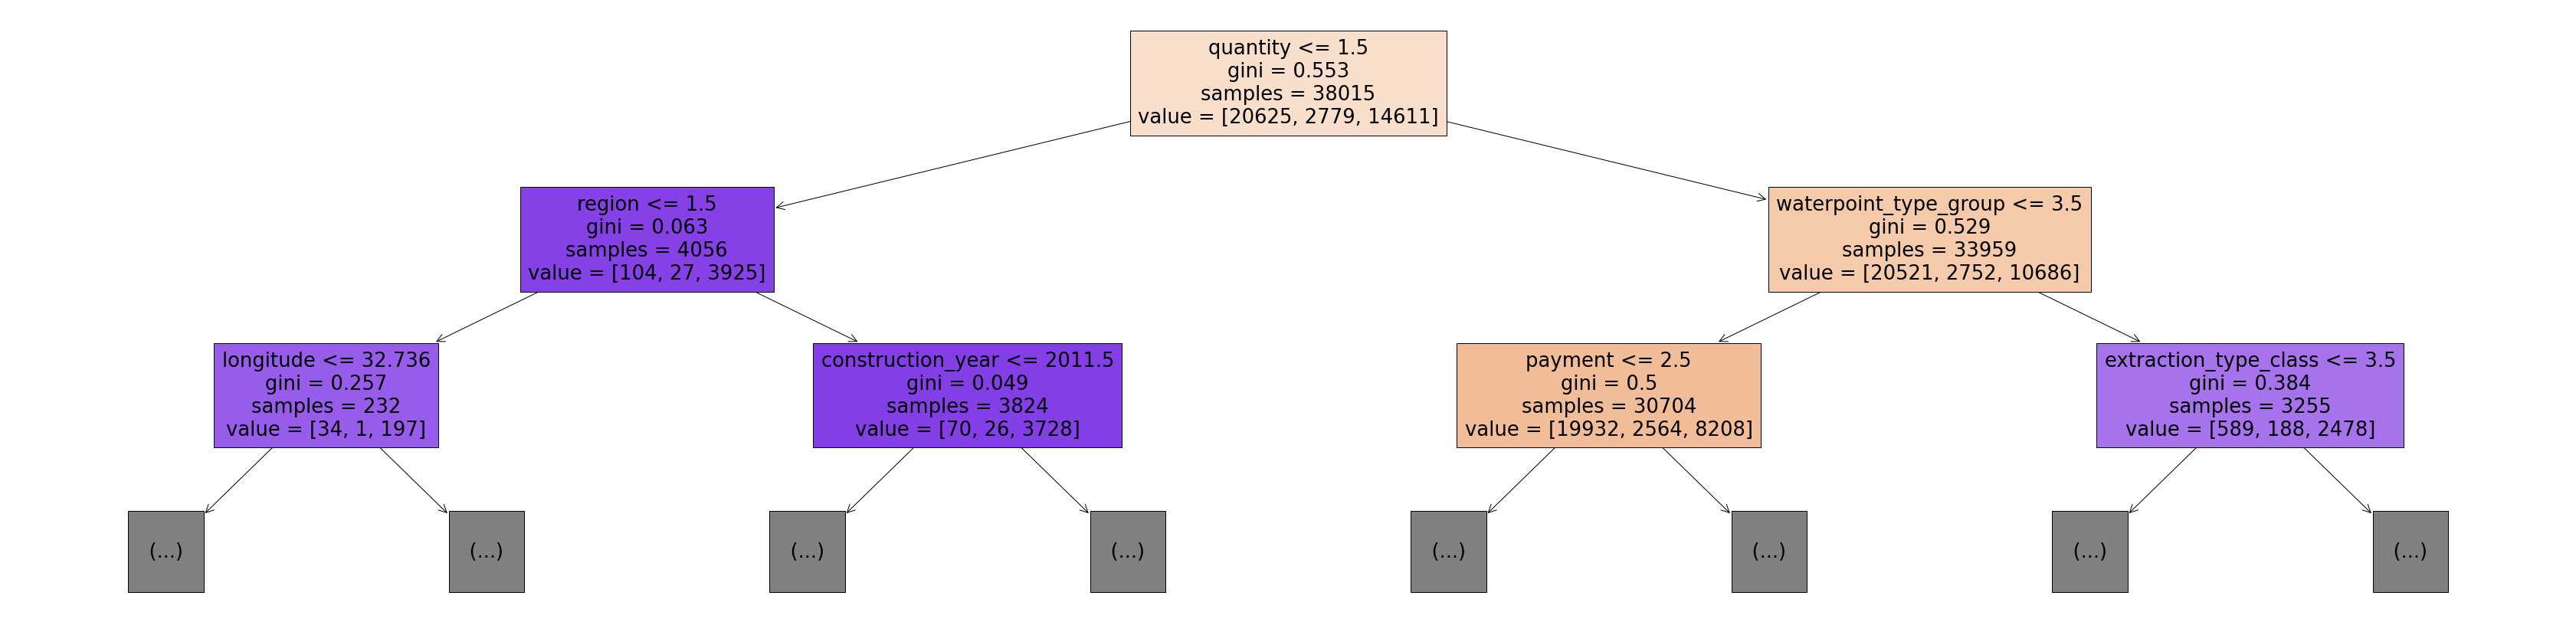

In [12]:
plt.figure(figsize=(60,15));
plot_tree(model_dt.named_steps['decisiontreeclassifier'],
         max_depth=2,
         feature_names=X_train.columns,
         filled=True
         );

**Second Model:** Random Forest

In [23]:
#Random Forest 
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1, max_samples=0.4)

)

model_rf .fit(X_train, y_train);

# V. Check Metrics

In [14]:
print('TREE: Training Accuracy:', model_dt.score(X_train, y_train))
print('TREE: Validation Accuracy:', model_dt.score(X_val, y_val))

TREE: Training Accuracy: 0.995475470209128
TREE: Validation Accuracy: 0.7403198653198653


In [24]:
print('FOREST: Training Accuracy:', model_rf.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_rf.score(X_val, y_val))

FOREST: Training Accuracy: 0.929790872024201
FOREST: Validation Accuracy: 0.79871632996633


# VI. Tune Model

In [20]:
train_acc = []
val_acc = []
max_samples_list = np.arange(0.2,1,0.1)
for sample in max_samples_list:
  model_rf_tune = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1, max_samples=sample)
)
  model_rf_tune.fit(X_train, y_train)
  
  

  train_acc.append(model_rf_tune.score(X_train, y_train))
  val_acc.append(model_rf_tune.score(X_val, y_val))

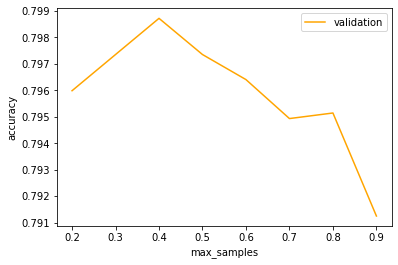

In [22]:
plt.plot(max_samples_list, train_acc, color='blue', label='training')
plt.plot(max_samples_list, val_acc, color='orange', label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# VII. Communicate Results

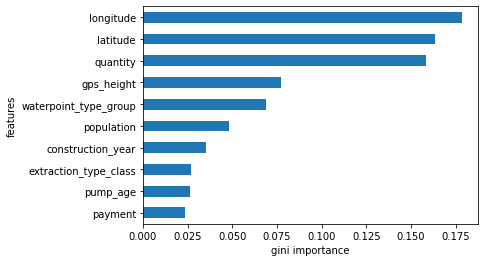

In [13]:
# decision Tree
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

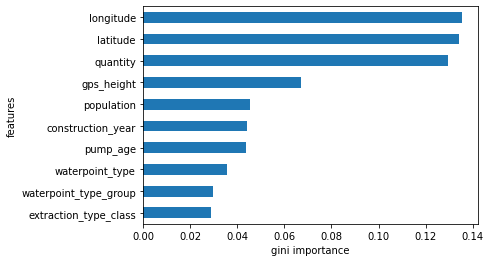

In [25]:
# random forest

features = model_rf.named_steps['ordinalencoder'].get_feature_names()
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

In [27]:
#first tree in the Random Forest
model_rf.named_steps['randomforestclassifier'].estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=1608637542)

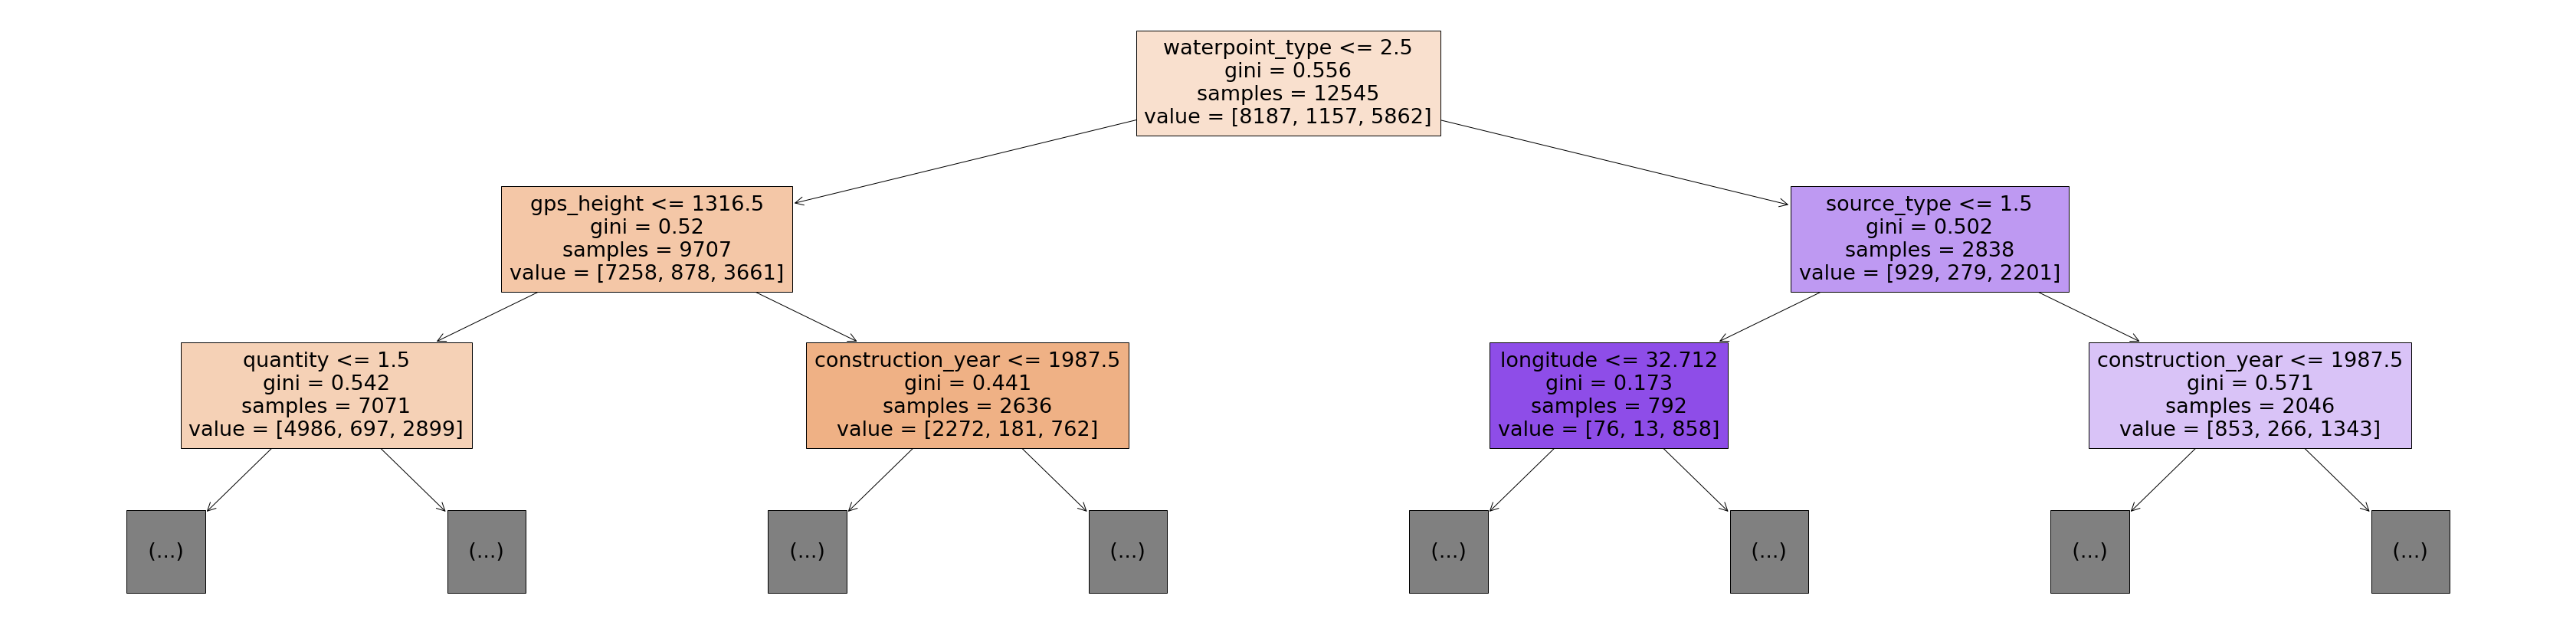

In [28]:
#first tree in the Random Forest
plt.figure(figsize=(60,15));
plot_tree(model_rf.named_steps['randomforestclassifier'].estimators_[0],
         max_depth=2,
         feature_names=X_train.columns,
         filled=True
         );